# Выявление профилей потребления (E-commerce)

Исследование на данных транзакций интернет-магазина товаров для дома и быта «Пока все ещё тут».

Целью исследования является выявление профилей потребилетей для составления рекомендаций для интернет-рассылок пользователям: сегментируем покупателей и решим, на какие сегменты стоит тратить ресурсы, а какие не являются для нас перспективными.

Ход исследования:
1. Загрузка таблицы и предвариельная обработка: проверка пропусков, дубликатов, имезнение типов данных, удаление выбросов.
2. Исследовательский анализ данных: присвоение товарам категорий, определение сезонности товароы, проведение RFM-анализа.
3. Оценка качества разбиения покупателей на категории с помощью статистических гипотез.
4. Рекомендации для отдела маркетинга по тому, как стоит проводить рассылки покупателям: какие сегменты самые перспективные, а на какие не стоит тратить ресурсы.

Импортируем бибиотеки и посмотрим на таблицу.

In [1]:
import pandas as pd
import warnings
import datetime
import matplotlib.pyplot as plt
import plotly.express as px
from scipy import stats as st
import numpy as np
import scipy.stats as stats
from IPython.display import Image

In [2]:
pd.set_option('display.max_rows', 200) #настраиваем максимальное количество строк для отображения 
pd.set_option('display.max_colwidth', None) #настраиваем вывод таблиц, чтобы видеть всю информацию

In [3]:
data = pd.read_csv(r'ecom_dataset_upd.csv', delimiter=',')

## Предобработка данных

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7474 entries, 0 to 7473
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         7474 non-null   int64  
 1   customer_id  7474 non-null   object 
 2   order_id     7474 non-null   int64  
 3   product      7474 non-null   object 
 4   quantity     7474 non-null   int64  
 5   price        7474 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 350.5+ KB


В исходных данных 6 столбцов и 7474 строк.

Столбцы:

  - `date` — дата заказа;
  - `customer_id` — идентификатор покупателя;
  - `order_id` — идентификатор заказа;
  - `product` — наименование товара;
  - `quantity` — количество товара в заказе;
  - `price` — цена товара.

Пропусков нет.

Добавим столбец с ценой заказа.

In [5]:
data['total'] = data['quantity'] * data['price']

Формат даты неверный, исправим его.

In [6]:
data['date'] = data['date'].astype('str').apply(lambda x: datetime.datetime.strptime(x, '%Y%m%d%H'))

Добавим столбец с датой без времени.

In [7]:
data['date_cut'] = pd.to_datetime(data['date'], format='%Y-%m-%d').dt.date
data['date_cut'] = pd.to_datetime(data['date_cut'])

Проверим, какой период описывают предоставленные данные.

In [8]:
d1 = data['date'].min()
d2 = data['date'].max()
print(f'Предоставленные данные описывают события с {d1} по {d2}.')

Предоставленные данные описывают события с 2018-10-01 00:00:00 по 2020-01-31 15:00:00.


Проверим явные и неявные дубликаты и удалим их.

In [9]:
print('Количество явных дубликатов в таблице users:', data.duplicated().sum())

Количество явных дубликатов в таблице users: 0


In [10]:
dupl_list = data[data[['customer_id', 'order_id', 'product', 'quantity']].duplicated()].index.tolist()
data = data.drop(index=dupl_list)

Посмотрим, есть ли выбросы.


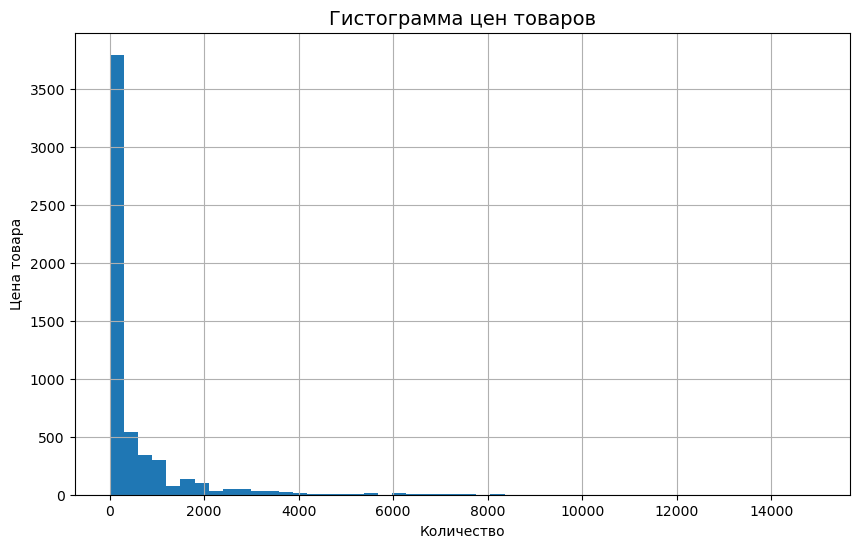

In [11]:
plt.figure(figsize=(10, 6))
data['price'].hist(bins = 50)
plt.title('Гистограмма цен товаров', fontsize=14)
plt.ylabel('Цена товара')
plt.xlabel('Количество')
plt.show()

In [12]:
data.loc[data['price'] < 20]

,date,customer_id,order_id,product,quantity,price,total,date_cut
160,2018-10-09 09:00:00,c971fb21-d54c-4134-938f-16b62ee86d3b,68580,"Стяжка оконная с болтом СТ-55 цинк, 1108354",64,19.0,1216.0,2018-10-09
211,2018-10-11 14:00:00,cd09ea73-d9ce-48c3-b4c5-018113735e80,68611,"Крепеж для пружины дверной, 1107055",150,19.0,2850.0,2018-10-11
277,2018-10-16 22:00:00,42c5db22-6046-455b-a728-ff163a1b7808,68667,Муляж Красное яблоко мини полиуретан d-6 см,30,19.0,570.0,2018-10-16
801,2018-11-13 11:00:00,2330d859-e9cb-4c8f-abd0-55f9e27e6745,68985,"Паста для полировки ""ГОИ"" 25 гр",1,15.0,15.0,2018-11-13
975,2018-11-25 14:00:00,52aff75c-a972-4c25-bad5-dfe6a48cd981,14512,"Бархатцы Веселая полянка 0,3 г 4660010777505",1,11.0,11.0,2018-11-25
977,2018-11-25 14:00:00,52aff75c-a972-4c25-bad5-dfe6a48cd981,14512,Морковь Детская сладость 2 г 4660010775921,1,10.0,10.0,2018-11-25
978,2018-11-25 14:00:00,52aff75c-a972-4c25-bad5-dfe6a48cd981,14512,Настурция Драгоценность вишнево-розовая 1 г 4660010773316,1,12.0,12.0,2018-11-25
979,2018-11-25 14:00:00,52aff75c-a972-4c25-bad5-dfe6a48cd981,14512,"Огурец Засолочный 0,3 г 4660010776102",1,10.0,10.0,2018-11-25
1069,2018-12-03 11:00:00,2c8b9386-2e8c-4ee9-8aa4-2b4875b68578,14514,"Алиссум (лобулярия) Снежные одежды 0,2 г 4650091480302",2,9.0,18.0,2018-12-03
1070,2018-12-03 11:00:00,2c8b9386-2e8c-4ee9-8aa4-2b4875b68578,14514,"Гвоздика турецкая Роковая страсть 0,05 г 4660010773231",1,12.0,12.0,2018-12-03


Действительно, в данных много товаров по низкой цене, что соответствует их реальной цене.

In [13]:
data.loc[data['price'] > 6000]

,date,customer_id,order_id,product,quantity,price,total,date_cut
634,2018-11-05 02:00:00,639c4989-b0ab-412a-b7ec-be394cb2d372,68856,Сумка-тележка хозяйственная Rolser IMX005 marengo Logic DOS+2 серая,1,6007.0,6007.0,2018-11-05
654,2018-11-05 22:00:00,fc333417-1d11-4a2a-b946-0957ae0603e9,68872,Сумка-тележка хозяйственная Rolser MOU041 malva RD6 сиреневая,1,7597.0,7597.0,2018-11-05
655,2018-11-05 22:00:00,639c4989-b0ab-412a-b7ec-be394cb2d372,68871,Сумка-тележка хозяйственная Rolser IMX005 marengo Logic DOS+2 серая,1,6007.0,6007.0,2018-11-05
1121,2018-12-06 17:00:00,82b56a76-0dc9-4dae-aa76-863a9a80f082,69236,Покрывало жаккард KARNA стеганое KALVEN 260x260 см наволочки 50х70 см 2 шт 8681914002162,1,6134.0,6134.0,2018-12-06
1241,2018-12-17 17:00:00,86c97bf1-c834-423e-9e38-8acda68f97e8,69417,Гладильная доска Leifheit AirBoard Compact M Plus 120х38 см малиновый 71630,1,7424.0,7424.0,2018-12-17
1420,2018-12-29 09:00:00,ad66d870-22f5-43bc-958f-73420822586b,69681,"Сумка-тележка хозяйственная Rolser Pack Gloria Logic RG серая, PAC036 marengo LOGIC RG",1,6307.0,6307.0,2018-12-29
1693,2019-02-04 16:00:00,282d20b5-8d00-424f-b339-7adf6c7c16d1,70094,"Сиденье для гладильной доски Leifheit Niveau, 71325",1,6149.0,6149.0,2019-02-04
1981,2019-02-24 10:00:00,ac250053-a236-467a-97d2-ddbb9bf4a1ba,70423,"Сумка-тележка хозяйственная Andersen Alu Star Shopper, Hava, синяя 115-103-90",1,8437.0,8437.0,2019-02-24
2339,2019-03-14 18:00:00,27d4ce42-352b-4756-bf5b-8724e05d5131,70740,Сумка-тележка хозяйственная Rolser IMX006 bassi Logic Tour бордовая,1,7679.0,7679.0,2019-03-14
2691,2019-04-05 14:00:00,02adb72a-3067-45e9-a3b5-f93d79d7496a,71030,"Сумка-тележка хозяйственная Andersen Scala Shopper Plus, Lini, синяя 133-108-90",1,6149.0,6149.0,2019-04-05


Цены дорогих товаров также соответствуют действительности, удалять их не будем.

Посмотри на возможные выбросы по количеству товаров.

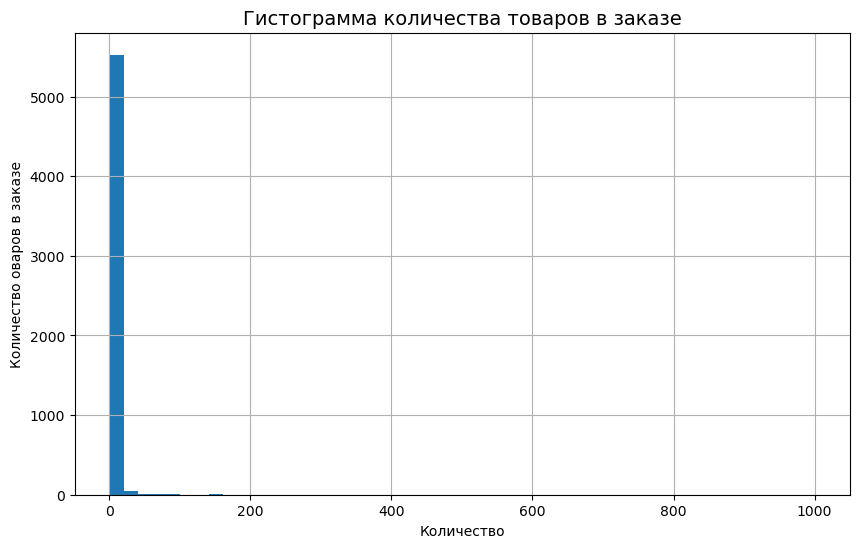

In [14]:
plt.figure(figsize=(10, 6))
data['quantity'].hist(bins = 50)
plt.title('Гистограмма количества товаров в заказе', fontsize=14)
plt.ylabel('Количество оваров в заказе')
plt.xlabel('Количество')
plt.show()

In [15]:
data.loc[data['quantity'] > 50]

,date,customer_id,order_id,product,quantity,price,total,date_cut
13,2018-10-01 15:00:00,0948b0c2-990b-4a11-b835-69ac4714b21d,68486,"Крючок одежный 2-х рожковый серый металлик с полимерным покрытием *Тонар*, 1110027",96,38.0,3648.0,2018-10-01
160,2018-10-09 09:00:00,c971fb21-d54c-4134-938f-16b62ee86d3b,68580,"Стяжка оконная с болтом СТ-55 цинк, 1108354",64,19.0,1216.0,2018-10-09
211,2018-10-11 14:00:00,cd09ea73-d9ce-48c3-b4c5-018113735e80,68611,"Крепеж для пружины дверной, 1107055",150,19.0,2850.0,2018-10-11
212,2018-10-11 14:00:00,cd09ea73-d9ce-48c3-b4c5-018113735e80,68611,"Пружина дверная 240 мм оцинкованная (Д-19 мм) без крепления, 1107014",150,38.0,5700.0,2018-10-11
568,2018-11-01 08:00:00,aa42dc38-780f-4b50-9a65-83b6fa64e766,68815,Муляж ЯБЛОКО 9 см красное,170,51.0,8670.0,2018-11-01
586,2018-11-02 11:00:00,0c5aaa88-e346-4f87-8f7a-ad8cbc04e965,68831,Муляж ЯБЛОКО 9 см красное,140,59.0,8260.0,2018-11-02
1023,2018-11-29 17:00:00,8fba3604-ef57-4b9f-b2fe-3402fa8825c8,69156,Набор ножей Attribute CHEF 5 предметов AKF522,64,457.0,29248.0,2018-11-29
1103,2018-12-04 17:00:00,7d255526-fcc2-4f79-b28a-217d7d2373a8,69206,"Щетка для посуды *ОЛЯ*, Мультипласт 1807010",100,26.0,2600.0,2018-12-04
1158,2018-12-10 14:00:00,a984c5b7-ff7e-4647-b84e-ef0b85a2762d,69289,"Ручка-скоба РС-100 белая *Трибатрон*, 1108035",200,29.0,5800.0,2018-12-10
1299,2018-12-21 16:00:00,6987e6d6-a63a-4ce2-a2d0-f424092d235e,69504,Тележка багажная DELTA ТБР-22 синий грузоподъемность 20 кг сумка и 50 кг каркас РОССИЯ,57,574.0,32718.0,2018-12-21


Было несколько больших закупок некоторых товаров, вероятно оптовая закупка. 1000 вантузов похоже на выброс, удалим его.

In [16]:
data = data.drop(5456)

Проверим наличие заказов, совершенных более чем одним покупателем.

In [17]:
data.groupby('order_id')['customer_id'].nunique().sort_values()

order_id
12624    1
72315    1
72320    1
72321    1
72322    1
        ..
71226    2
72790    2
71480    3
69485    3
72845    4
Name: customer_id, Length: 3520, dtype: int64

Есть номера заказов, которые присвоены нескольким уникальным customer_id. Это ошибка, удалим такие заказы.

In [18]:
data = data.groupby('order_id').filter(lambda x: x['customer_id'].nunique() < 2)

Перейдем к исследовательскому анализу данных.

## Анализ данных

### Категоризация товаров

Необходимо разделить все товары на категории. Проверим уникальные значения.

In [19]:
data['product'].value_counts()

Пеларгония розебудная Red Pandora укорененный черенок                              65
Пеларгония розебудная Prins Nikolai укорененный черенок                            54
Пеларгония зональная диам. 12 см сиреневый полумахровый                            53
Сумка-тележка 2-х колесная Gimi Argo синяя                                         47
Пеларгония розебудная Mary укорененный черенок                                     40
                                                                                   ..
Штора для ванной комнаты ПВХ 180х180 см Ракушки бежевая, 5923                       1
Чехол для гладильной доски I LOVE GIMI M из полиэстера и хлопка 132*48 см, Gimi     1
Петля рояльная цинк 960 мм, 1103055                                                 1
Сушилка для белья Hausmann Hermes De Luxe 20 м 03-010C-1                            1
Сумка-тележка хозяйственная Rolser BAB010 rojo JOY-1800 красная                     1
Name: product, Length: 2333, dtype: int64

В данных 2343 уникальных названия продуктов. 

In [20]:
data.loc[data['product'].str.lower().str.contains('^(?!.*см|черенок|л).*настурция|укроп|томата|петрушка|цинния|базилик|однолетнее растение|волгоградец|вербейник|незабудка|р-9|0,1 г|календула|0,3 г|0,05 г|попсокс|лимонад|0,5 г|0,02 г|0,2 г|скальный|рукола|0,04 г|детская сладость|каскад смесь|10,0 г|георгина черная|астра альпийская|лилейник высокорослый'), 'category'] = 'семена'
data.loc[data['product'].str.lower().str.contains('комнатное|0,75 л|d-11|d-15|d-23|диам|рассада|черенок|0,5 л|кориандр|пеларгония|овсянница|горш|зверобой|d-21|d-12|12 см|d-9|d- 9|d12|d-7|d-14|d-13|d-17|d-5|d-10|d-20|d20|h-20|дерево|котовник|примула комнатная|маяк|гвоздика травянка|антуриум|седум|нивянник|p9|камнеломка|в кассете|цикламен|папоротник|энотера|пиретрум|вероника|бегония|аквилегия|кашпо|хризантема сиреневая|осина|монарда|d-19|бузульник|солидаго|бадан|гипсофила|штук в упаковке|калла крупноцветковая|louvre'), 'category'] = 'рассада/комнатные растения/живые цветы'
data.loc[data['product'].str.lower().str.contains('ведр|кномойка|кофр|веник|подголовник|ящик|контейнер|совок|ключница|подвесное кашпо|комод|швабра|фоторамка|постельное|рукав|пододеяльник|микрофибр|полотен|бензин|полки|eva|тряпкодержатель|сетка для стирки|бак для белья|мыльница|ванна|губка|пробка|короб стеллажный|сметка|наматрацник|глаж|халат|этажерка|насадка-моп|штор|одеяло|гладильной|зажигалка|подрукавник|стакан для ванной|сиденье|покрывало|вкладыши|коробка|урна|ткань|термометр|свистком|эмалированный|пуф|ваза|мешок для деликатной|корзинка|соковарка|заварочный|салфет|подушка|ёрш|полотенце|рассекатель пламени|скребок для окон|наволочка|ванной|тряпка|туале|простын|прищеп|стремянк|вантуз|перчатки|скатерть|плед|мусорный|180х200|почтовый|дозатор|обув|коврик|ерш|гладильная|сумка|корзина|крючок|вешал|ролик|плечики|тележка|сушилка|таз|чехол|щетка|придверный|для мытья окон|скребок 44 см|подставка для цветов|фен дорожный|пылесос|электрическ|миксер|светильник|электронн|соковыжималка|весы|пароварка|электроштопор|утюг|зубная|пена|налета|для чистки|чистящий|концентр|кондиционер для белья|порошок|мыло|увлажняющая|засор|средство для мытья|антижир|бальзам для мытья|соль|ополаскиватель|антинакипин'), 'category'] = 'товары для дома и дачи'
data.loc[data['product'].str.lower().str.contains('муляж|искуст|искусств'), 'category'] = 'декор'
data.loc[data['product'].str.lower().str.contains('терка|блюдо|блюдце|крышка|лопатка|миска|котел|хлебница|салатник|масленка|банка|толкушка|сахарница|мантоварка|отделитель|ковш|лоток|яйц|шприц|тортница|картофелемялка|набор стаканов|венчик|многофункциональный инструмент|бокал|кастрюля|овощечистка|столовых|набор посуды|сотейник|мерный|кувшин|просеиватель|фужер|свч|корыто|дуршлаг|скалка|стакан низкий|стакан пластмассовый|термос|пресс|овощеварка|орехоколка|кружка|пив|выпечк|бидон|тepмокружка|тарелк|ложк|вилк|нож|сковород|половник|противень|бульонница|разделочная|кекс|сито|чайный|рыбочистка|скребок кондитерский'), 'category'] = 'посуда'
data.loc[data['product'].str.lower().str.contains('сверел|сверло|капроновый|петля|стяжка|штангенциркуль|крепеж|пружина|линейка|сварка|шнур|скоба|шпагат|напильник|шило|завертка форточная|фиксатор-шар|решетка|шпингалет|мешок для строительного|угольник|полировк|веревка|уголок оконный|ручка мебельная|набор инструментов'), 'category'] = 'ремонт'

Проверим, точно ли все товары попали в какую-либо категорию.

In [21]:
data.loc[data['category'].isna()]

,date,customer_id,order_id,product,quantity,price,total,date_cut,category


Таких товаров нет, все товары распределились по категориям.

Посмотрим, сколько наименований товаров попало в каждую категорию.

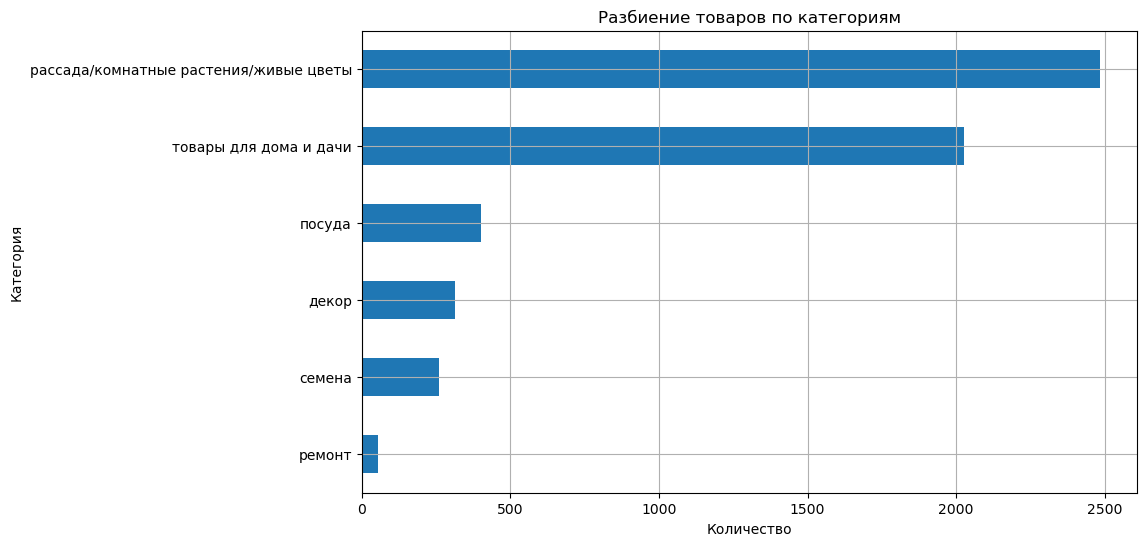

In [22]:
plt.figure(figsize=(10, 6))

data.groupby('category')['order_id'].count()\
                                    .sort_values(ascending=True)\
                                    .plot(kind = 'barh', grid = True)
plt.title('Разбиение товаров по категориям')
plt.xlabel('Количество')
plt.ylabel('Категория')


plt.show()

Мы видим две основные категории: рассада/комнатные растения и товары для дома и дачи. Также есть четыре более мелкие категории: посуда, декор, семена и ремонт.

Посмотрим, какие категории самые прибыльные.

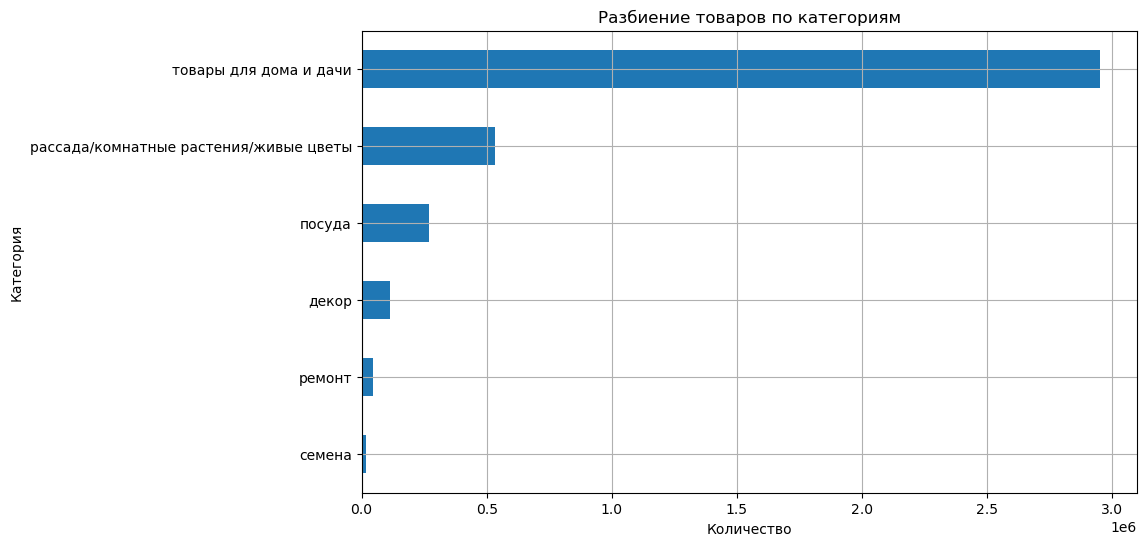

In [23]:
plt.figure(figsize=(10, 6))

data.groupby('category')['total'].sum()\
                                    .sort_values(ascending=True)\
                                    .plot(kind = 'barh', grid = True)
plt.title('Разбиение товаров по категориям')
plt.xlabel('Количество')
plt.ylabel('Категория')


plt.show()

По суммарным продажам очередность категорий изменилась: самой прибыльной с большим отрывом оказались товары для дома и дачи, а четыре последние категории занимают совсем незначительную часть наших продаж.

### Анализ категорий

Посмотрим на разброс цен и сезонность для каждой категории.

#### Рассада/комнатные растения

In [24]:
rasten = data.loc[data['category'] == 'рассада/комнатные растения/живые цветы']

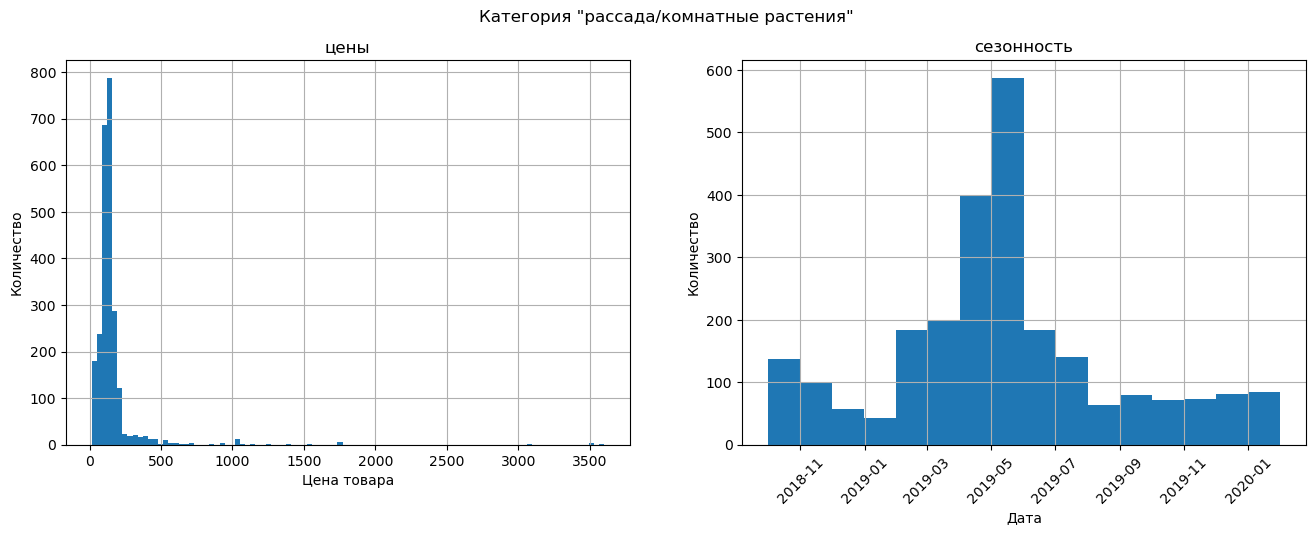

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

axes[0].hist(rasten['price'], bins = 100) 
axes[0].grid()
axes[0].set_xlabel('Цена товара')
axes[0].set_ylabel('Количество')
axes[0].set_title('цены')

axes[1].hist(rasten['date'], bins = 16) 
axes[1].grid()
axes[1].set_xlabel('Дата')
axes[1].set_ylabel('Количество')
axes[1].set_title('сезонность')
plt.xticks(rotation=45)

plt.suptitle('Категория "рассада/комнатные растения"');

In [26]:
rasten.loc[data['price'] > 1000].head()

,date,customer_id,order_id,product,quantity,price,total,date_cut,category
80,2018-10-04 09:00:00,32de7df8-8d4f-4c84-a7b9-c41d00dd83ba,68522,Эвкалипт Гунни d-17 см h-60 см,1,1409.0,1409.0,2018-10-04,рассада/комнатные растения/живые цветы
327,2018-10-19 17:00:00,a4726e06-e517-4941-b591-ff4857aeb3f6,68698,Афеляндра скуарроса Дания Микс в кашпо с автополивом,1,3524.0,3524.0,2018-10-19,рассада/комнатные растения/живые цветы
1126,2018-12-07 14:00:00,e7601af1-7604-4a01-9873-b5f1d1f85793,69245,Фаленопсис королевский Голубой 1 ствол d-12 см,1,1034.0,1034.0,2018-12-07,рассада/комнатные растения/живые цветы
1222,2018-12-16 17:00:00,682f54c9-0ee1-4442-9145-670a2c6f1970,69388,Новогоднее дерево Ель сербская d-21 см h-60 см,1,1049.0,1049.0,2018-12-16,рассада/комнатные растения/живые цветы
1224,2018-12-16 18:00:00,db3795d2-a180-4269-81b6-f35848d754a1,69390,Новогоднее дерево Ель канадская Коника в красном ведерке 3 л h-40 см,1,1237.0,1237.0,2018-12-16,рассада/комнатные растения/живые цветы


In [27]:
rasten.loc[data['price'] < 100].head()

,date,customer_id,order_id,product,quantity,price,total,date_cut,category
22,2018-10-02 11:00:00,f08d9018-438e-4e96-b519-f74c0302a433,14480,"Многолетнее растение Тимьян-чабрец розовый объем 0,5 л",1,89.0,89.0,2018-10-02,рассада/комнатные растения/живые цветы
61,2018-10-02 21:00:00,29a514f5-a27e-4939-85d5-874a0c3f7a2c,68510,Суккулент Микс d-5 см,1,74.0,74.0,2018-10-02,рассада/комнатные растения/живые цветы
481,2018-10-28 02:00:00,6e8c1c71-9e9c-49ed-96d4-513d6a587b43,14499,"Хризантема Корейская смесь окрасок объем 0,75 л",1,97.0,97.0,2018-10-28,рассада/комнатные растения/живые цветы
482,2018-10-28 08:00:00,3ee43256-af7d-4036-90d4-eeefa1afc767,14500,"Многолетнее растение Душица-орегано розовый объем 0,5 л",1,89.0,89.0,2018-10-28,рассада/комнатные растения/живые цветы
483,2018-10-28 08:00:00,3ee43256-af7d-4036-90d4-eeefa1afc767,14500,"Многолетнее растение Тимьян-чабрец розовый объем 0,5 л",1,89.0,89.0,2018-10-28,рассада/комнатные растения/живые цветы


Цены варьируются от совсем невысоких (менее 100р) до 2-3 тыс руб за дорогие комнатные растения.

Видим, что есть ярко-выраженная сезонность: пик покупок товаров этой категории приходится на весенне-летний период (с марта по июль).

#### Товары для дома и дачи

In [28]:
dlya_doma = data.loc[data['category'] == 'товары для дома и дачи']

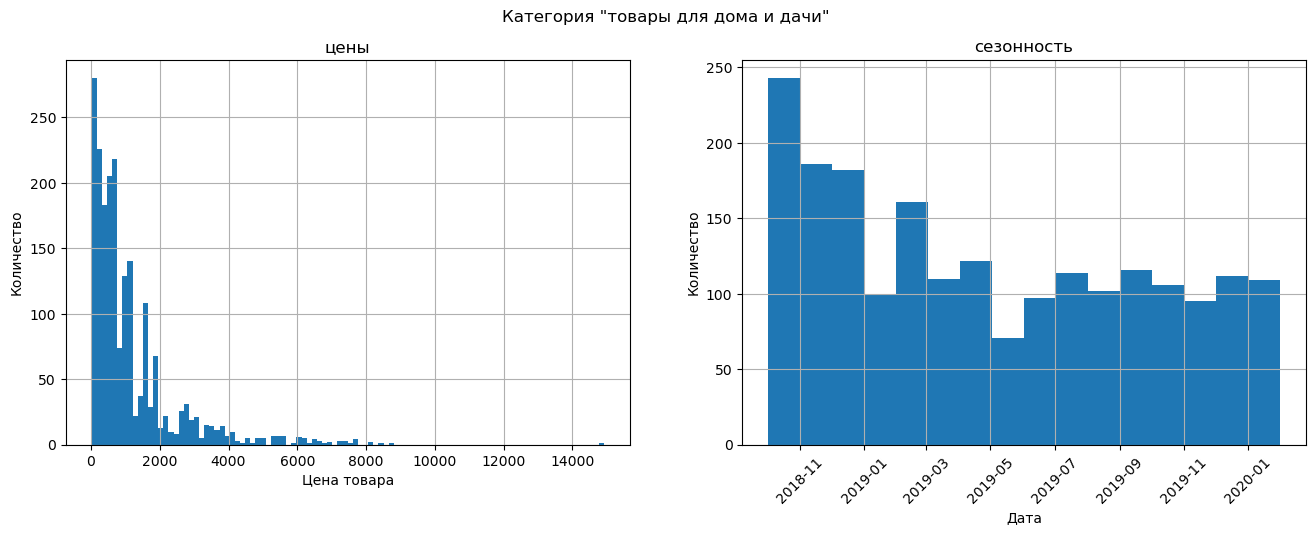

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

axes[0].hist(dlya_doma['price'], bins = 100) 
axes[0].grid()
axes[0].set_xlabel('Цена товара')
axes[0].set_ylabel('Количество')
axes[0].set_title('цены')

axes[1].hist(dlya_doma['date'], bins = 16) 
axes[1].grid()
axes[1].set_xlabel('Дата')
axes[1].set_ylabel('Количество')
axes[1].set_title('сезонность')
plt.xticks(rotation=45)

plt.suptitle('Категория "товары для дома и дачи"');

In [30]:
dlya_doma.loc[data['price'] > 8000].head()

,date,customer_id,order_id,product,quantity,price,total,date_cut,category
1981,2019-02-24 10:00:00,ac250053-a236-467a-97d2-ddbb9bf4a1ba,70423,"Сумка-тележка хозяйственная Andersen Alu Star Shopper, Hava, синяя 115-103-90",1,8437.0,8437.0,2019-02-24,товары для дома и дачи
2697,2019-04-05 19:00:00,c0c60544-3a99-49d0-8a8e-cf7f293c22cb,71035,"Сумка-тележка хозяйственная Andersen Royal Shopper, Hera, синяя 166-004-90",1,8737.0,8737.0,2019-04-05,товары для дома и дачи
2997,2019-04-21 16:00:00,19d904d8-8d16-476d-8f66-b2a3b7a23660,71227,Сумка-тележка хозяйственная Rolser MNB019 rojo LOGIC DOS+2 красная,1,8077.0,8077.0,2019-04-21,товары для дома и дачи
5992,2019-07-29 17:00:00,0d87f4ae-465a-4fac-81e6-5d629761783e,72139,Сушилка уличная Leifheit 85210 LINOMATIC V 400 40 м 175х237х237 см зеленая,1,14917.0,14917.0,2019-07-29,товары для дома и дачи
7436,2020-01-26 19:00:00,04416514-5346-4f90-93e3-fb7365e2ee8c,109758,Сумка-тележка хозяйственная Rolser MNB019 rojo LOGIC DOS+2 красная,1,8077.0,8077.0,2020-01-26,товары для дома и дачи


In [31]:
dlya_doma.loc[data['price'] < 100].head()

,date,customer_id,order_id,product,quantity,price,total,date_cut,category
10,2018-10-01 11:00:00,161e1b98-45ba-4b4e-8236-e6e3e70f6f7c,68483,"Вешалка для брюк металлическая с резиновым покрытием 26 см цвет: синяя, Attribute, AHS331",10,82.0,820.0,2018-10-01,товары для дома и дачи
13,2018-10-01 15:00:00,0948b0c2-990b-4a11-b835-69ac4714b21d,68486,"Крючок одежный 2-х рожковый серый металлик с полимерным покрытием *Тонар*, 1110027",96,38.0,3648.0,2018-10-01,товары для дома и дачи
42,2018-10-02 11:00:00,4d93d3f6-8b24-403b-a74b-f5173e40d7db,68493,"Щетка-сметка 3-х рядная деревянная 450 мм (плоская ручка), Поиск Риф 1801095",15,49.0,735.0,2018-10-02,товары для дома и дачи
43,2018-10-02 11:00:00,4d93d3f6-8b24-403b-a74b-f5173e40d7db,68493,"Щетка-сметка 4-х рядная деревянная 300 мм (фигурная ручка) ворс 5,5 см 1801096",15,70.0,1050.0,2018-10-02,товары для дома и дачи
64,2018-10-03 08:00:00,c971fb21-d54c-4134-938f-16b62ee86d3b,68511,Набор прищепок большие пластиковые ROZENBAL ПИНОККИО 10 шт R102312,10,86.0,860.0,2018-10-03,товары для дома и дачи


Разброс цен также велик, что нормально для данной категории товаров.

Сезонности у товаров данной категории нет, продажи достаточно равномерные, но заметен тренд на снижение продаж.

#### Посуда

In [32]:
posuda = data.loc[data['category'] == 'посуда']

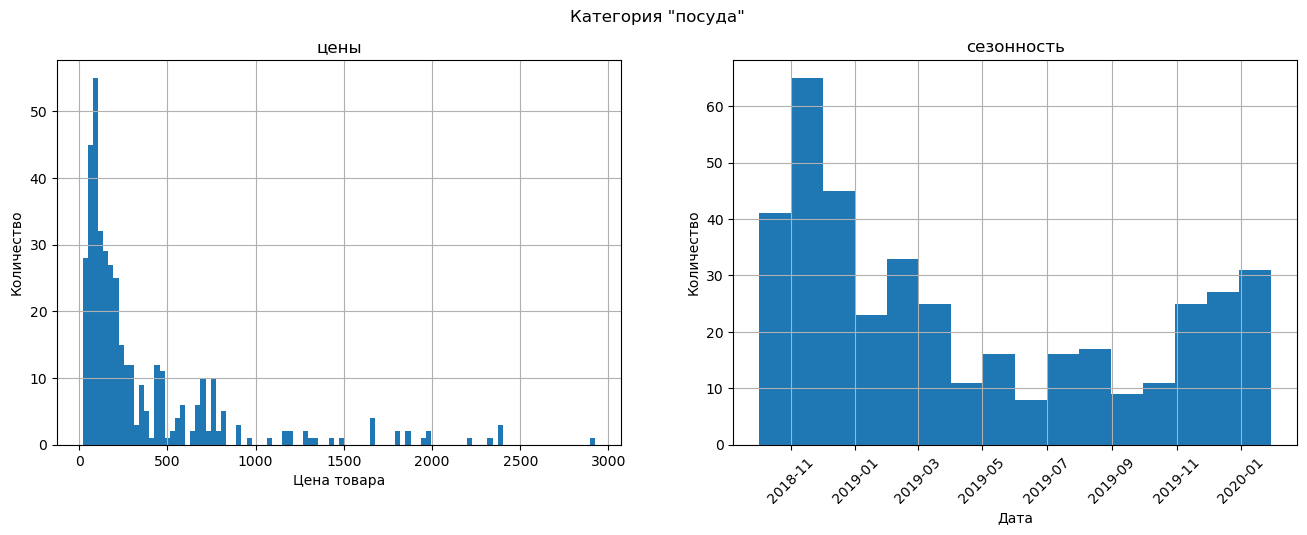

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

axes[0].hist(posuda['price'], bins = 100) 
axes[0].grid()
axes[0].set_xlabel('Цена товара')
axes[0].set_ylabel('Количество')
axes[0].set_title('цены')

axes[1].hist(posuda['date'], bins = 16) 
axes[1].grid()
axes[1].set_xlabel('Дата')
axes[1].set_ylabel('Количество')
axes[1].set_title('сезонность')
plt.xticks(rotation=45)

plt.suptitle('Категория "посуда"');

In [34]:
posuda.loc[data['price'] > 2000]

,date,customer_id,order_id,product,quantity,price,total,date_cut,category
57,2018-10-02 18:00:00,649c4398-a4c4-4d01-b29b-f14704ce6e17,68508,"Котел алюминиевый 70,0 л без крышки Балезино, Хозлэнд, 1502050",1,2924.0,2924.0,2018-10-02,посуда
256,2018-10-15 09:00:00,092ef2d7-30d2-4d15-9c40-35af6973f28b,68650,Tepмокружка AVEX Recharge 500 мл голубой AVEX0681,1,2324.0,2324.0,2018-10-15,посуда
1566,2019-01-22 11:00:00,f6503cb7-d28a-4704-8495-c791bd702471,69918,Мантоварка-пароварка WEBBER BE-81 нержавеющая сталь d=30 см,1,2219.0,2219.0,2019-01-22,посуда
2419,2019-03-21 14:00:00,036d75ea-b633-41a8-8974-3f84fee8c65e,70822,Tepмокружка AVEX Freeflow 700 мл зеленый AVEX0759,1,2399.0,2399.0,2019-03-21,посуда
6110,2019-08-16 02:00:00,2eef43dd-ad75-4e55-a46d-edea403bcb6b,72306,Tepмокружка AVEX Freeflow 700 мл сталь AVEX0776,1,2399.0,2399.0,2019-08-16,посуда
7467,2020-01-29 17:00:00,4228e34b-dcba-4df8-ae70-b282e84a1edb,110547,Tepмокружка AVEX Freeflow 700 мл зеленый AVEX0759,1,2399.0,2399.0,2020-01-29,посуда


In [35]:
posuda.loc[data['price'] < 100].head()

,date,customer_id,order_id,product,quantity,price,total,date_cut,category
77,2018-10-04 09:00:00,e64aad3a-fffc-4193-8df5-e94a43eff295,68521,"Нож для чистки овощей WEBBER из нержавеющей стали 12х6,8х1,5 см ВЕ-5275",1,52.0,52.0,2018-10-04,посуда
159,2018-10-09 08:00:00,98e660a4-b3ab-4abb-a94c-ae393f109d02,68579,"Банка со стеклянной крышкой, COLOR SERIES, круглая, 7*7,6*12,5 см, 280 мл VALIANT, JP-S280",2,60.0,120.0,2018-10-09,посуда
351,2018-10-21 22:00:00,73622418-6eda-4c65-9334-afe0c2a92d1b,68712,"Нож для тонкой нарезки ALPENKOK из нержавеющей стали пилообразный ""Comfort"" 12,7 см синий AK-2082",2,74.0,148.0,2018-10-21,посуда
448,2018-10-27 15:00:00,2b9225f9-65ab-4c12-9579-0698ebacb5a3,68771,"Ножеточка универсальная ""Рыбка"" 1519028",2,67.0,134.0,2018-10-27,посуда
591,2018-11-02 14:00:00,d17d26f1-8829-4350-a6ab-f0d6fb6e4f2e,68834,Салатник Luminarc КУТЮР 16 см H3386,1,82.0,82.0,2018-11-02,посуда


Цены в этой категории в основном до 1000 руб, и есть небольшое количество более дорогих товаров.

Продажи посуды в весенне-летний период падают.

#### Декор

In [36]:
dekor = data.loc[data['category'] == 'декор']

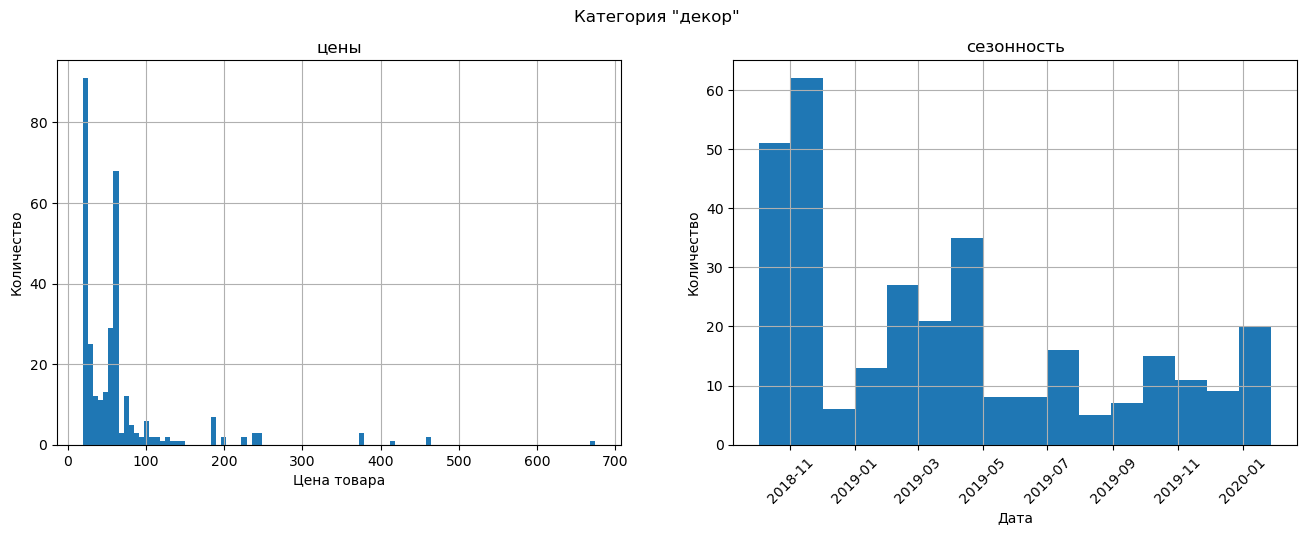

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

axes[0].hist(dekor['price'], bins = 100) 
axes[0].grid()
axes[0].set_xlabel('Цена товара')
axes[0].set_ylabel('Количество')
axes[0].set_title('цены')

axes[1].hist(dekor['date'], bins = 16) 
axes[1].grid()
axes[1].set_xlabel('Дата')
axes[1].set_ylabel('Количество')
axes[1].set_title('сезонность')
plt.xticks(rotation=45)

plt.suptitle('Категория "декор"');

Цены на декор невысокие: до 700 рублей. Сезонность не выражена, ощущается тренд на снижение продаж.

#### Семена

In [38]:
semena = data.loc[data['category'] == 'семена']

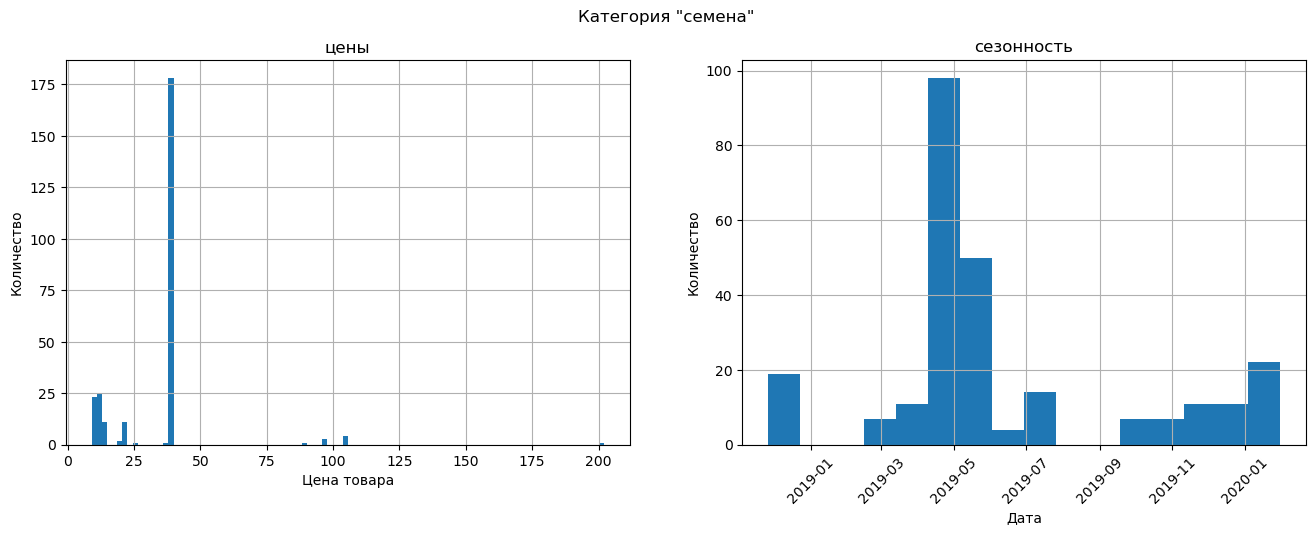

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

axes[0].hist(semena['price'], bins = 100) 
axes[0].grid()
axes[0].set_xlabel('Цена товара')
axes[0].set_ylabel('Количество')
axes[0].set_title('цены')

axes[1].hist(semena['date'], bins = 16) 
axes[1].grid()
axes[1].set_xlabel('Дата')
axes[1].set_ylabel('Количество')
axes[1].set_title('сезонность')
plt.xticks(rotation=45)

plt.suptitle('Категория "семена"');

Цены на семена колеблятся от 10 до 200 рублей, ярко-выражена сезонность: товар продается в начале посадочного сезона в мае.

#### Ремонт

In [40]:
remont = data.loc[data['category'] == 'ремонт']

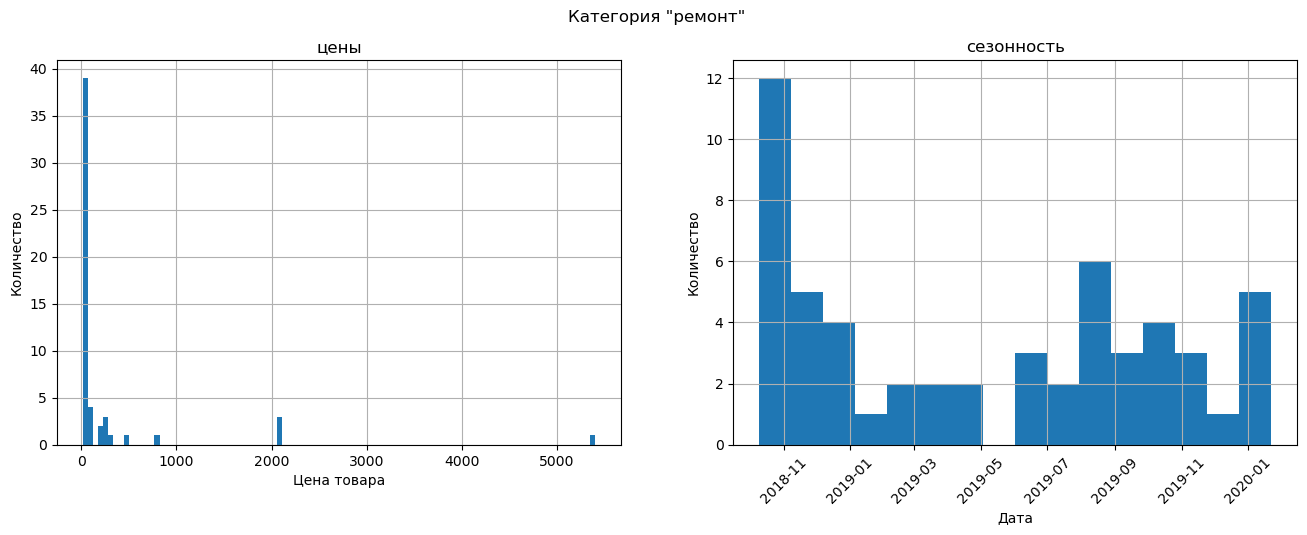

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

axes[0].hist(remont['price'], bins = 100) 
axes[0].grid()
axes[0].set_xlabel('Цена товара')
axes[0].set_ylabel('Количество')
axes[0].set_title('цены')

axes[1].hist(remont['date'], bins = 16) 
axes[1].grid()
axes[1].set_xlabel('Дата')
axes[1].set_ylabel('Количество')
axes[1].set_title('сезонность')
plt.xticks(rotation=45)

plt.suptitle('Категория "ремонт"');

In [42]:
remont.loc[data['price'] > 2000]

,date,customer_id,order_id,product,quantity,price,total,date_cut,category
1947,2019-02-22 03:00:00,09a5e5d4-be3f-4c62-a2c6-8bb3f2c39df5,70398,"Фал капроновый 6 мм в бухте 300м Т-1, 1201050",1,2099.0,2099.0,2019-02-22,ремонт
6100,2019-08-15 13:00:00,16e422c6-94fe-4ccf-9c97-05493f3e99c4,72302,Набор инструментов в алюминиевом кейсе на колесиках с ручкой КУЗЬМИЧ 187 предметов НИК-001/187,1,5399.0,5399.0,2019-08-15,ремонт
7346,2020-01-16 14:00:00,fbafa598-bc5e-448d-baf8-92fbe38c4cb7,107369,"Фал капроновый 6 мм в бухте 300м Т-1, 1201050",1,2099.0,2099.0,2020-01-16,ремонт
7364,2020-01-17 19:00:00,76615b86-9e6a-47d9-a98d-989b3e15e6e7,101825,"Фал капроновый 6 мм в бухте 300м Т-1, 1201050",1,2099.0,2099.0,2020-01-17,ремонт


Цены от 20 рублей до 5 тыс за набор инструментов. Сезонность не прослеживается. Опять же видим снижение продаж по сравнению с началом рассматриваемого периода.

### Определение пороговых значений для RFM-анализа

Суть метода: определить ключевых клиентов, разделив их в зависимости от того, как давно они сделали покупку (R - recency), как часто они ее делали (F - frequency) и сколько денег потратили за рассматриваемый период (M - monetary).  

Для Recency это выглядит следующим образом: 

1 – клиенты, которые совершали покупки очень давно;\
2 – относительно недавние клиенты;\
3 – только пришедшие клиенты.

Frequency:

1 – клиент совершает очень мало покупок, обычно не превосходит единоразового визита;\
2 - клиент приходит за покупками, но не часто;\
3 – постоянный покупатель, который часто взаимодействует с продуктом.

Monetary:

1 – небольшая сумма покупки;\
2 - средние затраты;\
3 – крупная сумма, которую потратил клиент за все время.

Нам необходимо определить градацию для RFM.

#### Recency

Датафрейм описывает события с 1 октября 18 года по 31 января 20 года.

Построим гистограмму последних заказов каждого клиента.

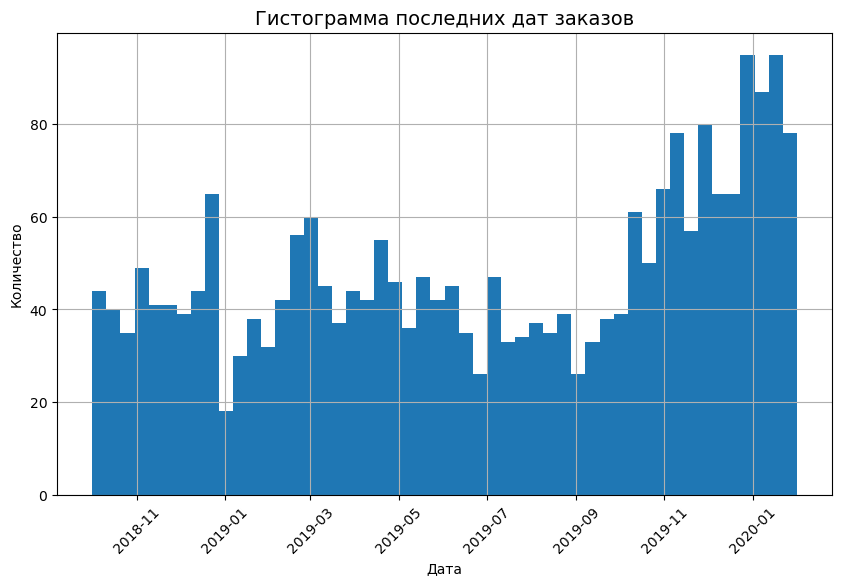

In [43]:
plt.figure(figsize=(10, 6))
data.groupby('customer_id')['date'].max().hist(bins = 50)
plt.title('Гистограмма последних дат заказов', fontsize=14)
plt.ylabel('Количество')
plt.xlabel('Дата')
plt.xticks(rotation=45)
plt.show()

За последние заказы (3) можем принять два последний месяца: декабрь 19 и январь 20 года. За средние (2) примем клиентов с мая по ноябрь 19. И все клиенты до мая 19 мы примем за неактивных клиентов (1), они не совершали покупок более 9 месяцев.

Внесем эти данные в таблицу.

In [44]:
grouped = data.groupby('customer_id')['date_cut'].max()
data['last_order'] = data['customer_id'].apply(lambda x: grouped[x])

In [45]:
data.loc[data['last_order'] <= '2019-04-30', 'recency'] = '1'
data.loc[(data['last_order'] >= '2019-05-01') & (data['last_order'] <= '2019-11-30'), 'recency'] = '2'
data.loc[data['last_order'] >= '2019-12-01', 'recency'] = '3'

#### Frequency

Построим гистограмму числа покупок каждого покупателя на разных масштабах.

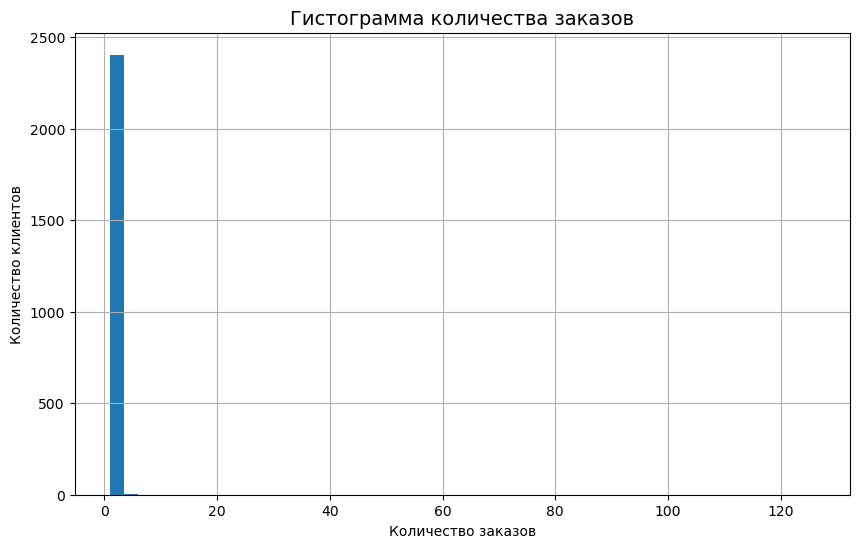

In [46]:
plt.figure(figsize=(10, 6))
data.groupby('customer_id')['order_id'].nunique().hist(bins = 50)
plt.title('Гистограмма количества заказов', fontsize=14)
plt.ylabel('Количество клиентов')
plt.xlabel('Количество заказов')
plt.show()

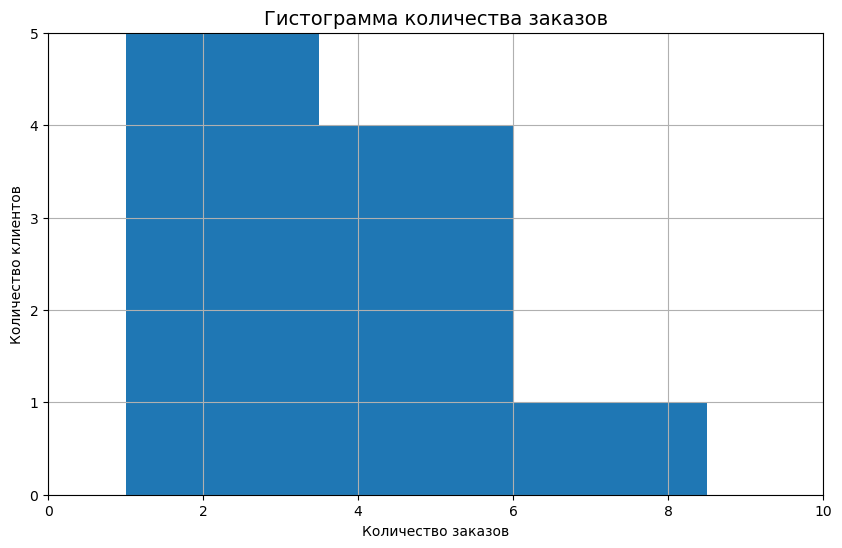

In [47]:
plt.figure(figsize=(10, 6))
data.groupby('customer_id')['order_id'].nunique().hist(bins = 50)
plt.title('Гистограмма количества заказов', fontsize=14)
plt.ylabel('Количество клиентов')
plt.xlabel('Количество заказов')
plt.ylim(0, 5)
plt.xlim(0, 10)
plt.show()

Присвоим 1 тем клиентам, кто совершил 1 заказ за все время. 2 - клиентам, которые совершили более 2 заказов. И 3 клиентам, которые совешали заказы более 6 раз.

In [48]:
grouped = data.groupby('customer_id')['order_id'].nunique()
data['frequency'] = data['customer_id'].apply(lambda x: grouped[x])
data.head()

,date,customer_id,order_id,product,quantity,price,total,date_cut,category,last_order,recency,frequency
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0,142.0,2018-10-01,рассада/комнатные растения/живые цветы,2018-10-01,1,1
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12, h25",1,194.0,194.0,2018-10-01,рассада/комнатные растения/живые цветы,2018-10-01,1,1
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0,112.0,2018-10-01,рассада/комнатные растения/живые цветы,2018-10-01,1,1
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0,179.0,2018-10-01,рассада/комнатные растения/живые цветы,2018-10-01,1,1
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0,112.0,2018-10-01,рассада/комнатные растения/живые цветы,2018-10-01,1,1


In [49]:
data.loc[data['frequency'] == 1, 'frequency'] = 1
data.loc[(data['frequency'] > 1) & (data['frequency'] < 6) , 'frequency'] = 2
data.loc[data['frequency'] >= 6, 'frequency'] = 3

In [50]:
data['frequency'] = data['frequency'].astype('str')

#### Monetary

Построим гистограмму числа принесенных денег каждого покупателя на разных масштабах.

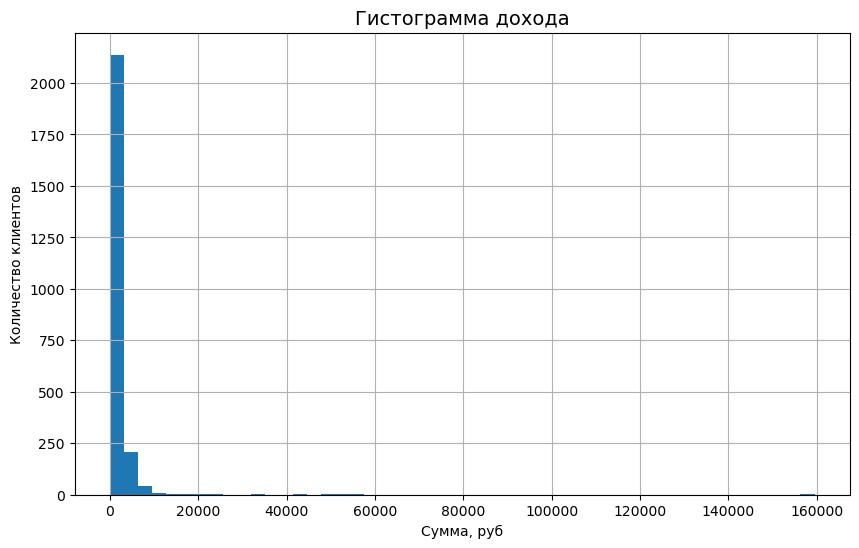

In [51]:
plt.figure(figsize=(10, 6))
data.groupby('customer_id')['total'].sum().hist(bins = 50)
plt.title('Гистограмма дохода', fontsize=14)
plt.ylabel('Количество клиентов')
plt.xlabel('Сумма, руб')
plt.show()

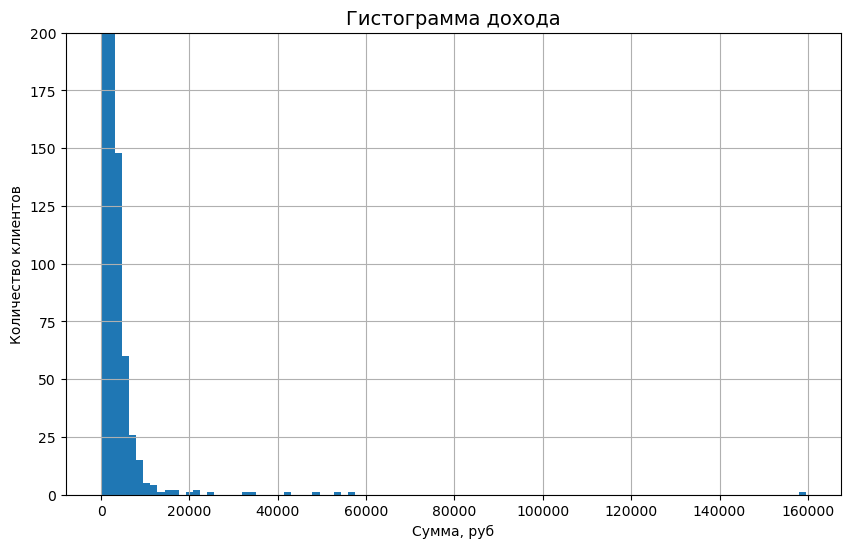

In [52]:
plt.figure(figsize=(10, 6))
data.groupby('customer_id')['total'].sum().hist(bins = 100)
plt.title('Гистограмма дохода', fontsize=14)
plt.ylabel('Количество клиентов')
plt.xlabel('Сумма, руб')
plt.ylim(0, 200)
plt.show()

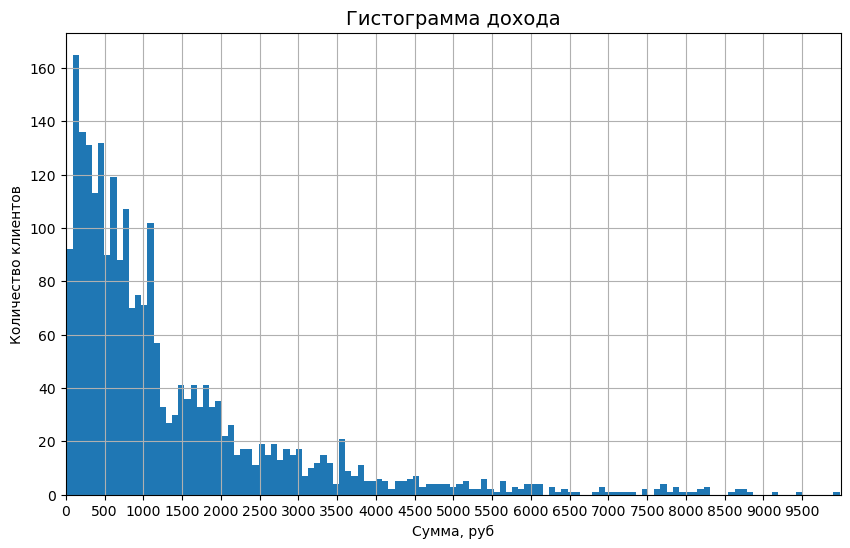

In [53]:
plt.figure(figsize=(10, 6))
data.groupby('customer_id')['total'].sum().hist(bins = 2000)
plt.title('Гистограмма дохода', fontsize=14)
plt.ylabel('Количество клиентов')
plt.xlabel('Сумма, руб')
plt.xlim(0, 10000)
plt.xticks(range(0, 10000, 500))
plt.show()

Присвоим 1 тем клиентам, у кого средние траты до 600 руб. 2 - до 4 тыс руб, и 4 - более 4 тыс руб.

In [54]:
grouped = data.groupby('customer_id')['total'].sum()
data['monetary'] = data['customer_id'].apply(lambda x: grouped[x])

In [55]:
data.loc[data['monetary'] < 600, 'monetary'] = 1
data.loc[(data['monetary'] >= 600) & (data['monetary'] <4000) , 'monetary'] = 2
data.loc[data['monetary'] >= 4000, 'monetary'] = 3

In [56]:
data['monetary'] = data['monetary'].astype('int').astype('str')

### RFM

#### Распределение клиентов по кластерам

Cоздадим новый столбец с итоговым значением RFM.

In [57]:
data['rfm'] = data['recency'] + data['frequency'] + data['monetary']

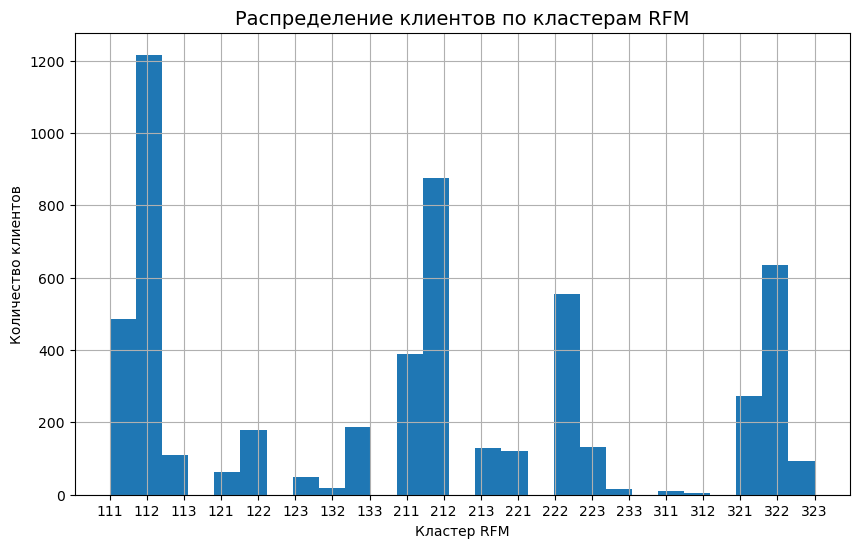

In [58]:
plt.figure(figsize=(10, 6))
data['rfm'].sort_values().hist(bins = 27)
plt.title('Распределение клиентов по кластерам RFM', fontsize=14)
plt.ylabel('Количество клиентов')
plt.xlabel('Кластер RFM')
plt.show()

#### Распределение клиентов по укрупненным кластерам

Укрупним похожие сегменты.

111, 112, 113, 121, 122, 123, 132, 133 - это старые  клиенты, которые уже более 9 месяцев не приходили в наш магазин. Вернуть таких клиентов будет довольно сложно. Назовем эту категорию "спящие".

211, 213, 212, 221, 222, 311 - это недавние клиенты, которые приходили один или несколько раз и потратили разные суммы. Назовем их "перспективные".

223, 233, 312, 321 - эти покупатели совершали покупки в последнее время, некоторые из них совершали покупки много раз, некоторые только одну, но совсем недавно. Они потратили разные суммы. Назовем их "лояльные".

322, 323 - самые перспективные клиенты: покупали недавно, делали несколько заказов, тратили средние либо большие суммы. Назовем их "чемпионы".

Разделим клиентов на получившиеся категории:

In [59]:
data.loc[data['rfm'].isin(['111', '112', '113', '121', '122','123', '132', '133']), 'rfm_category'] = 'спящие'
data.loc[data['rfm'].isin(['211', '213', '212', '221', '222', '311']), 'rfm_category'] = 'перспективные'
data.loc[data['rfm'].isin(['223', '233', '312', '321']), 'rfm_category'] = 'лояльные'
data.loc[data['rfm'].isin(['322', '323']), 'rfm_category'] = 'чемпионы'

Проверим, всем ли присвоилась категория rfm.

In [60]:
data.loc[data['rfm_category'].isna()]

,date,customer_id,order_id,product,quantity,price,total,date_cut,category,last_order,recency,frequency,monetary,rfm,rfm_category


Все в порядке. Посмотрим, как распределились клиенты по категориям.

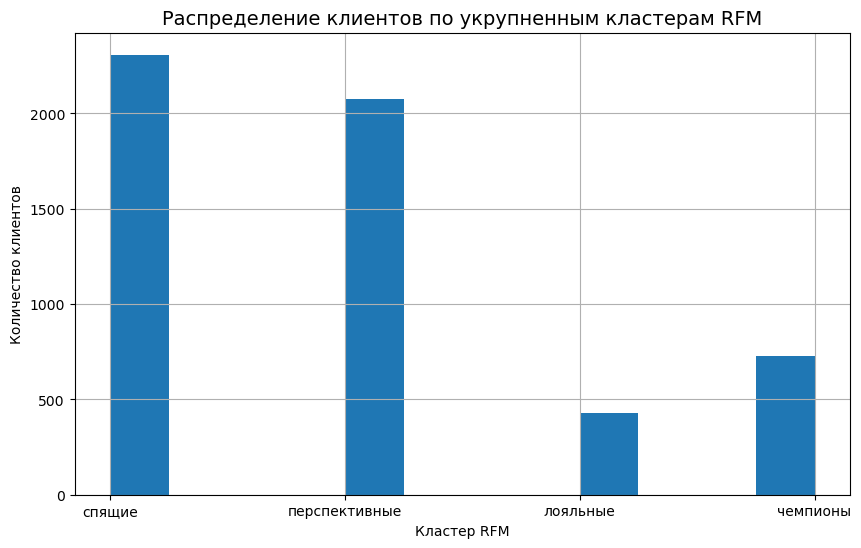

In [61]:
plt.figure(figsize=(10, 6))
data['rfm_category'].hist(bins = 12)
plt.title('Распределение клиентов по укрупненным кластерам RFM', fontsize=14)
plt.ylabel('Количество клиентов')
plt.xlabel('Кластер RFM')
plt.show()

#### Преобладающие категории покупок в разных кластерах

Теперь посмотрим, какие категории покупок преобладают в разных кластерах RFM.

Сначала рассмотрим это в разрезе количества покупателей.

In [62]:
rfm1 = data.groupby(['rfm_category','category'])\
                .agg({'customer_id': 'count'})
rfm1

customer_id
rfm_category  category                                           
лояльные      декор                                            22
              посуда                                           35
              рассада/комнатные растения/живые цветы          202
              ремонт                                            1
              семена                                           20
              товары для дома и дачи                          147
перспективные декор                                            68
              посуда                                          107
              рассада/комнатные растения/живые цветы         1135
              ремонт                                           19
              семена                                           99
              товары для дома и дачи                          650
спящие        декор                                           207
              посуда                                          203
              рассада/комнатные растения/живые цветы          989
              ремонт                                           25
              семена                                          125
              товары для дома и дачи                          759
чемпионы      декор                                            17
              посуда                                           58
              рассада/комнатные растения/живые цветы          157
              ремонт                                           10
              семена                                           17
              товары для дома и дачи                          469

In [63]:
rfm1 = rfm1.reset_index()

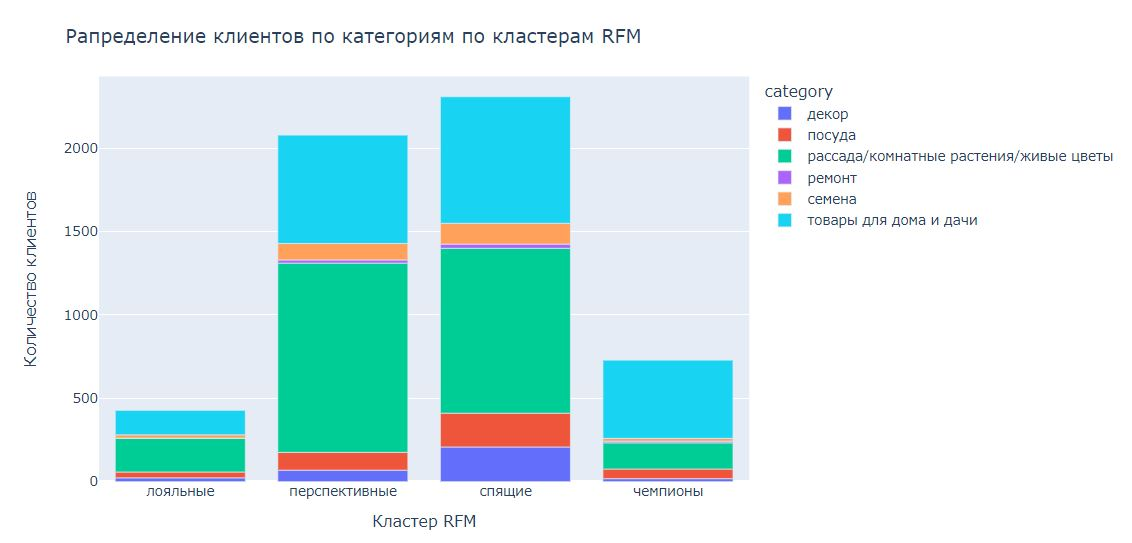

In [64]:
fig = px.bar(rfm1, 
             x='rfm_category', 
             y='customer_id', 
             color='category',
            category_orders={'rfm_category': rfm1['rfm_category'].sort_values()})
fig.update_layout(title='Рапределение клиентов по категориям по кластерам RFM',
                  xaxis_title='Кластер RFM',
                  yaxis_title='Количество клиентов',
                  height=500,
                  width=1000)
fig
Image("1.jpg")

#### Распределение дохода по категориям по кластерам

Теперь в разрезе полученного по кластерам дохода.

In [65]:
rfm = data.groupby(['rfm_category','category'])\
                .agg({'total': 'sum'})
rfm.head()

total
rfm_category category                                            
лояльные     декор                                    1306.666667
             посуда                                   5539.500000
             рассада/комнатные растения/живые цветы  33473.500000
             ремонт                                     32.000000
             семена                                    553.000000

In [66]:
rfm = rfm.reset_index()

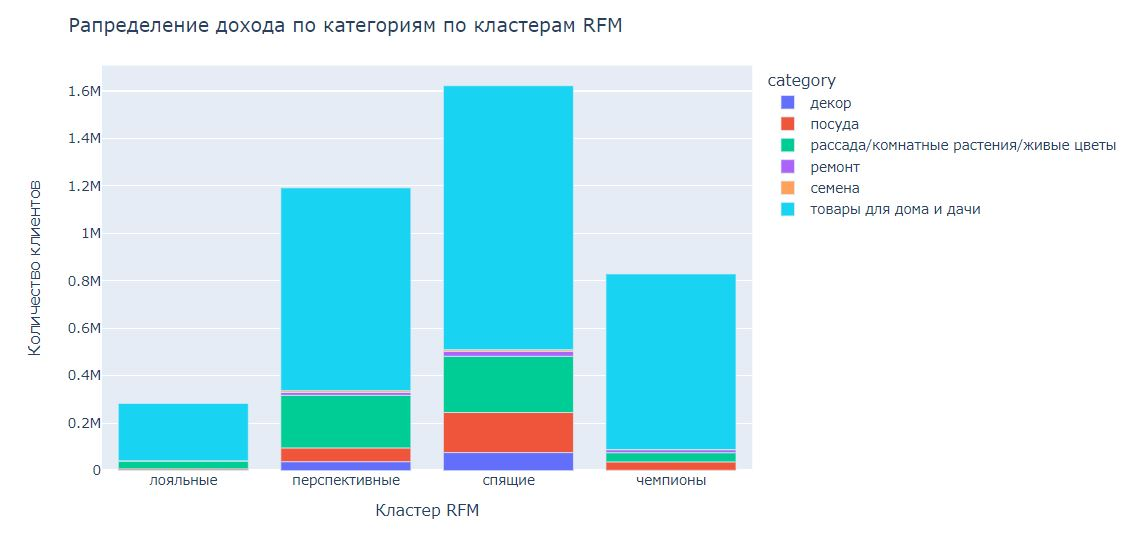

In [67]:
fig = px.bar(rfm, 
             x='rfm_category', 
             y='total', 
             color='category',
            category_orders={'rfm_category': rfm['rfm_category'].sort_values()})
fig.update_layout(title='Рапределение дохода по категориям по кластерам RFM',
                  xaxis_title='Кластер RFM',
                  yaxis_title='Количество клиентов',
                  height=500,
                  width=1000)
fig
Image("2.jpg")

#### Сезонность различных категорий товаров по кластерам

Проверим сезонность категорий товара по получившимся кластерам.

In [68]:
sezon = data.groupby(['rfm_category','date_cut', 'category'])\
                .agg({'order_id': 'count'})
sezon.head()

order_id
rfm_category date_cut   category                        
лояльные     2018-10-07 товары для дома и дачи         1
             2018-10-16 товары для дома и дачи         1
             2018-10-23 товары для дома и дачи         1
             2018-10-25 товары для дома и дачи         1
             2018-10-30 товары для дома и дачи         1

In [69]:
sezon = sezon.reset_index()

##### Сезонность покупок кластера "лояльные"

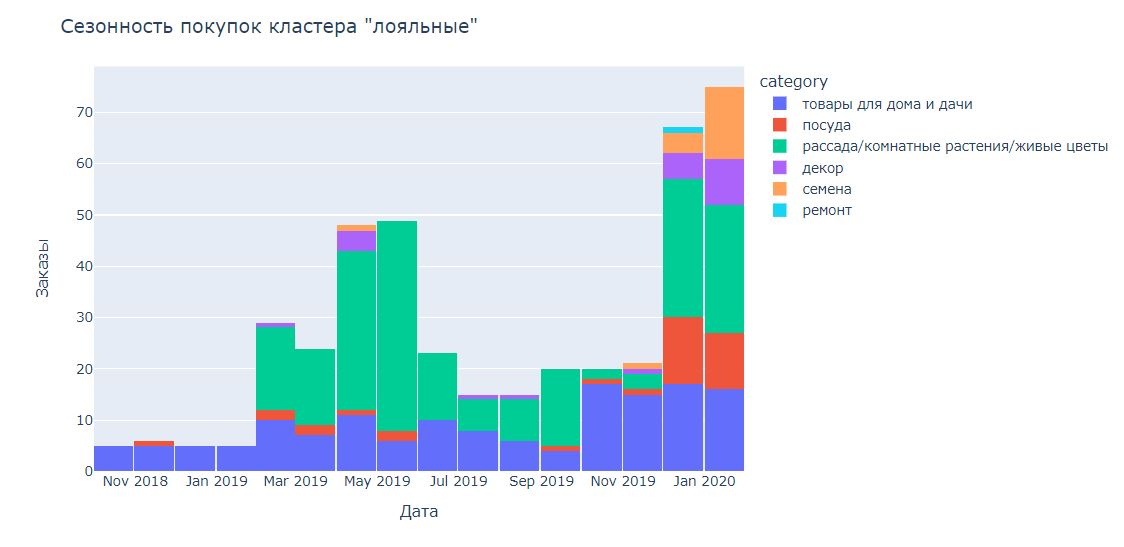

In [70]:
fig = px.histogram(sezon.loc[sezon['rfm_category'] == 'лояльные'], 
             x='date_cut', 
             y='order_id', 
             color='category')
fig.update_layout(title='Сезонность покупок кластера "лояльные"',
                  xaxis_title='Дата',
                  yaxis_title='Заказы',
                  height=500,
                  width=1000)
fig
Image("3.jpg")

Это кластер хорошо и равномерно покупает товары для дома, много рассады/растений (особенно в весенне-летний период), а также хорошо покупает посуду в последнее время. В целом категория не очень многочисленная.

##### Сезонность покупок кластера "перспективные"

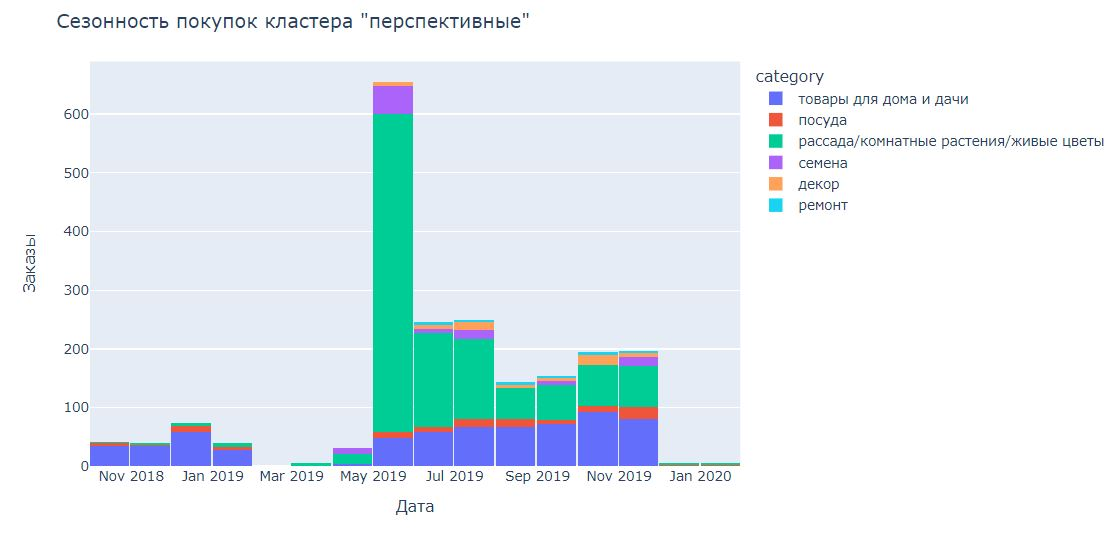

In [71]:
fig = px.histogram(sezon.loc[sezon['rfm_category'] == 'перспективные'], 
             x='date_cut', 
             y='order_id', 
             color='category')
fig.update_layout(title='Сезонность покупок кластера "перспективные"',
                  xaxis_title='Дата',
                  yaxis_title='Заказы',
                  height=500,
                  width=1000)
fig
Image("4.jpg")

Перспективные клиенты покупали очень много рассады и семен перед началом дачного сезона. Товары для дома покупались ими достаточно равномерно в течение года.

##### Сезонность покупок кластера "спящие"

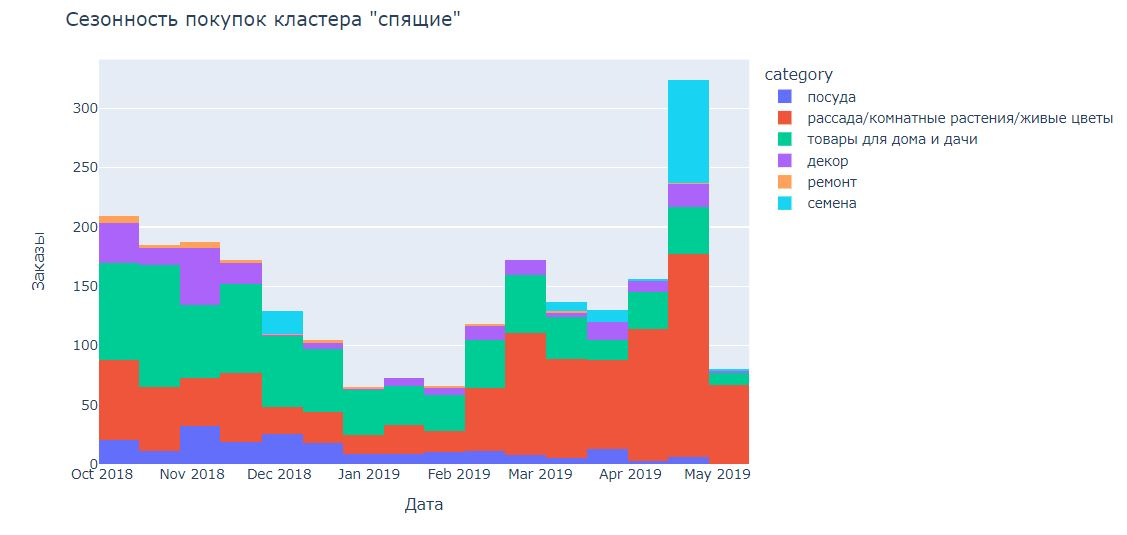

In [72]:
fig = px.histogram(sezon.loc[sezon['rfm_category'] == 'спящие'], 
             x='date_cut', 
             y='order_id', 
             color='category')
fig.update_layout(title='Сезонность покупок кластера "спящие"',
                  xaxis_title='Дата',
                  yaxis_title='Заказы',
                  height=500,
                  width=1000)
fig
Image("5.jpg")

Эти покупатели скорее всего не вернутся к нам, так как их последние покупки были более 9 мес назад. Заметно преобладает рассады и товаров для дома в их заказах.

##### Сезонность покупок кластера "чемпионы"

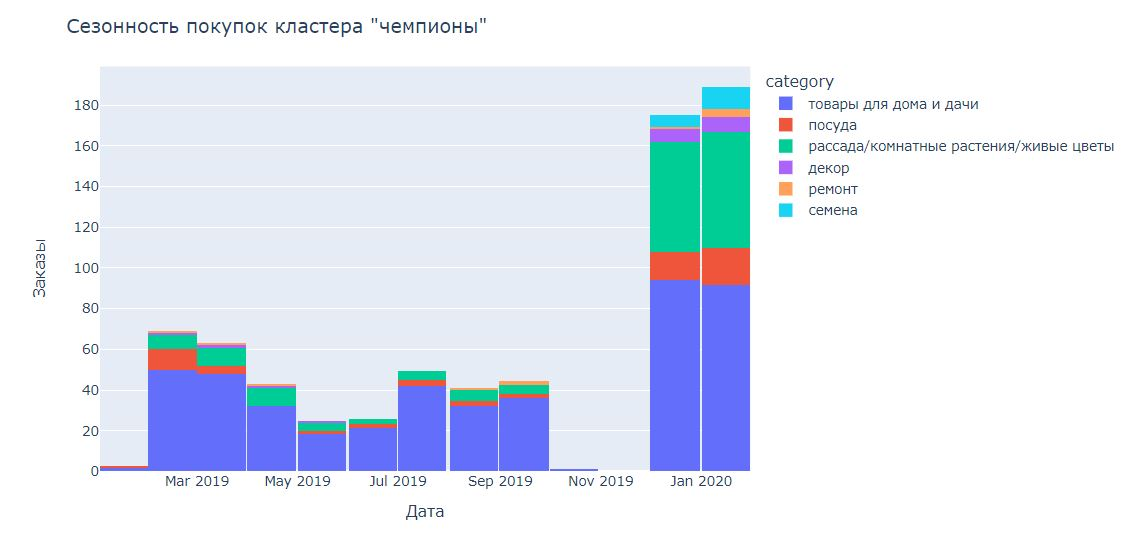

In [73]:
fig = px.histogram(sezon.loc[sezon['rfm_category'] == 'чемпионы'], 
             x='date_cut', 
             y='order_id', 
             color='category')
fig.update_layout(title='Сезонность покупок кластера "чемпионы"',
                  xaxis_title='Дата',
                  yaxis_title='Заказы',
                  height=500,
                  width=1000)
fig
Image("6.jpg")

Наши чемпионы покупаюттовары для дома и дачи, особенно много в последнее время, а также растения.

Получили разделение категорий товаров по кластерам и по сезонности. На основе этой информации мы можем дать рекомендации для отдела маркетинга для проведения рассылок.

Но сначала проверим стастистическими гипотезами, верно ли мы разделили клиентов на кластера.

### Проверка корректности разбиения кластеров

Проверим корректность разбиения с помощью двух гипотез: гипотезы о равенстве средних чеков кластеров и гипотезе о равенстве возвращаемости в разных кластерах.

Так как наше распределение не нормальное, применим статистический тест Манна - Уитни.

Вероятность получения ложного срабатывания возрастает при проведении нескольких проверок гипотез. Нам нужно провести шесть проверок, поэтому можно воспользоваться поправкой Бонферрони.

Уровень статистической значимости с учетом поправки:

In [74]:
print(f'Уровень стат. значимости с учетом поправки: {0.05/6}')

Уровень стат. значимости с учетом поправки: 0.008333333333333333


#### Проверка гипотезы о равенстве средних чеков

H0 - различий между чеками нет, H1 - различия есть.

In [75]:
def test_values(data):

    loyal_persp = stats.mannwhitneyu(data.loc[data['rfm_category'] == 'лояльные']['total'], data.loc[data['rfm_category'] == 'перспективные']['total'])[1]
    loyal_spyashie = stats.mannwhitneyu(data.loc[data['rfm_category'] == 'лояльные']['total'], data.loc[data['rfm_category'] == 'спящие']['total'])[1]
    loyal_champ = stats.mannwhitneyu(data.loc[data['rfm_category'] == 'лояльные']['total'], data.loc[data['rfm_category'] == 'чемпионы']['total'])[1]
    persp_spyashie = stats.mannwhitneyu(data.loc[data['rfm_category'] == 'перспективные']['total'], data.loc[data['rfm_category'] == 'спящие']['total'])[1]
    persp_champ = stats.mannwhitneyu(data.loc[data['rfm_category'] == 'перспективные']['total'], data.loc[data['rfm_category'] == 'чемпионы']['total'])[1]
    spyashie_champ = stats.mannwhitneyu(data.loc[data['rfm_category'] == 'спящие']['total'], data.loc[data['rfm_category'] == 'чемпионы']['total'])[1]
    
    
    test_values = pd.DataFrame({'Тестируемые группы': ['Лояльные и Перспективные', 'Лояльные и Спящие', 'Лояльные \
                                                  и Чемпионы', 'Перспективные и Спящие',  'Перспективные и Чемпионы', \
                                                'Спящие и Чемпионы'],
                                'p-value': [loyal_persp, loyal_spyashie, loyal_champ, \
                                            persp_spyashie,  persp_champ, spyashie_champ]})
    test_values['p-value'] = round(test_values['p-value'], 5)
    return test_values
    

In [76]:
test_values(data)

,Тестируемые группы,p-value
0,Лояльные и Перспективные,0.00041
1,Лояльные и Спящие,0.00000
2,Лояльные и Чемпионы,0.00000
3,Перспективные и Спящие,0.00051
4,Перспективные и Чемпионы,0.00000
5,Спящие и Чемпионы,0.00000


Значение p-value во всех тестах менее уровня стат значимости, а значит мы можем отвергнуть нулевую гипотезу. Принимаем альтернативную гипотезу: разница в средних чеках между разными сегментами клиентов есть.

#### Проверка гипотезы о возвращаемости клиентов в разных кластерах

H0 - различий по количеству повторых покупок нет, H1 - различия есть.

In [77]:
def test_values(data):

    loyal_persp = stats.mannwhitneyu(data.loc[data['rfm_category'] == 'лояльные'].groupby('order_id')['order_id'].count(), data.loc[data['rfm_category'] == 'перспективные'].groupby('order_id')['order_id'].count())[1]
    loyal_spyashie = stats.mannwhitneyu(data.loc[data['rfm_category'] == 'лояльные'].groupby('order_id')['order_id'].count(), data.loc[data['rfm_category'] == 'спящие'].groupby('order_id')['order_id'].count())[1]
    loyal_champ = stats.mannwhitneyu(data.loc[data['rfm_category'] == 'лояльные'].groupby('order_id')['order_id'].count(), data.loc[data['rfm_category'] == 'чемпионы'].groupby('order_id')['order_id'].count())[1]
    persp_spyashie = stats.mannwhitneyu(data.loc[data['rfm_category'] == 'перспективные'].groupby('order_id')['order_id'].count(), data.loc[data['rfm_category'] == 'спящие'].groupby('order_id')['order_id'].count())[1]
    persp_champ = stats.mannwhitneyu(data.loc[data['rfm_category'] == 'перспективные'].groupby('order_id')['order_id'].count(), data.loc[data['rfm_category'] == 'чемпионы'].groupby('order_id')['order_id'].count())[1]
    spyashie_champ = stats.mannwhitneyu(data.loc[data['rfm_category'] == 'спящие'].groupby('order_id')['order_id'].count(), data.loc[data['rfm_category'] == 'чемпионы'].groupby('order_id')['order_id'].count())[1]

    
    
    test_values = pd.DataFrame({'Тестируемые группы': ['Лояльные и Перспективные', 'Лояльные и Спящие', 'Лояльные \
                                                  и Чемпионы', 'Перспективные и Спящие',  'Перспективные и Чемпионы',\
                                                'Спящие и Чемпионы'],
                                'p-value': [loyal_persp, loyal_spyashie,  loyal_champ, \
                                            persp_spyashie, persp_champ,  spyashie_champ]})
    test_values['p-value'] = round(test_values['p-value'], 5)
    return test_values

In [78]:
test_values(data)

,Тестируемые группы,p-value
0,Лояльные и Перспективные,0.00000
1,Лояльные и Спящие,0.00000
2,Лояльные и Чемпионы,0.00002
3,Перспективные и Спящие,0.00000
4,Перспективные и Чемпионы,0.00000
5,Спящие и Чемпионы,0.00000


Значение p-value во всех тестах менее уровня стат значимости, а значит мы можем отвергнуть нулевую гипотезу. Принимаем альтернативную гипотезу: разница в количестве повторных покупок между разными сегментами покупателей есть.

Таким образом мы проверили корректность разбиения на кластера.

In [79]:
data['customer_id'].nunique()

2412

### Рекомендации для рассылки

Мы проанализировали логи интернет-магазина товаров для дома и быта «Пока все ещё тут» с 1 октября 18 по 31 января 19 года с информацией о дате заказа, id клиента, id заказа, товарах, количестве товаров и его цене. За это время было совершено 3491 заказа 2412 уникальных покупателей.

Мы выделили 6 категорий: две самые крупные рассада/комнатные растения и товары для дома и дачи и четыре более мелкие категории посуда, декор, семена и ремонт. Самым прибыльным направлением для бизнеса являются товары для дома, на втором месте растения/рассада. Посуда, декор, семена и ремонт - недоходные направления.

В результате исследования мы получили четыре, подтвержденные статистическими гипотезами, категории клиентов:

  - `Спящие` - это клиенты, которые не совершали покупок в нашем магазине более 9 месяцев. Вернуть таких клиентов будет сложно, поэтому стоит провести для них рассылку в самую последнюю очередь. Если выходить к ним с рассылками, то можно разослать предложения по рассаде и растениям до начала весеннего сезона, в феврале-марте, и предложения по семенам в апреле.
  
  
  - `Перспективные` - это недавние клиенты, которые приходили один или несколько раз и потратили разные суммы. Они совершали покупки в течение последних 9 месяцев, часть из них - постоянные покупатели, при этом люди в этой категории не тратят много денег. В течение всего года они покупают товары для дома и посуду, а вот рассаду, растения и семена они покупают передначалом летне-осеннего периода. Нам нужно периодически напоминать о себе рассылками с текущими акциями, а также сделать целевую рассылку перед началом дачного сезона: семена, рассада, растения со скидками. Важно не потерять контакт с этими покупателями, так как со временем они могут перейти в разряд Лояльных и Чемпионов.
  
- `Лояльные` - эти покупатели совершали покупки в последнее время, некоторые из них совершали покупки много раз, некоторые только одну, но совсем недавно. Они потратили разные суммы. Но всех покупателей объединяет то, что они лояльны к нам. Они помнят нас и вероятнее всего еще вернутся к нам. Нам важно поддерживать их лояльность: предложить зарегистрироваться в программе лояльности, присылать специальные предложения только для постоянных покупателей. В течение всего года эти клиенты покупают товары для дома; рассаду, семена и растения в течение весенне-летнего периода, и также в последнее время эти клиенты покупают много посуды и декора. Это самая малочисленная категория, принесшая самый низкий суммарный доход. Однако целевые рассылки могут улучшить этот показатель.


- `Чемпионы` - это наши "чемпионы" по ряду параметров: покупали недавно, делали несколько заказов, тратили средние либо большие суммы. Самый большой упор следует сделать на товарах для дома и посуда. Такие рассылки можно проводить круглогодично.


Общие рекомендации: категория "товары для дома" приносят самый высокий доход и больше всего интересна людям. Стоит сделать упор именно на развитие этой категории. "Рассаду/цветы" покупают тоже много, однако эта категория не такая прибыльная. Для нее имеет смысл искать оптовиков, учитывая сезонность товара (поиск оптовиков необходимо проводить до начала сезона). "Посуда" - перспективная категория: можно попробовать увеличить ассортимент и провести в осенне-зимний период общую рассылку о новых поступлениях. "Семена", "ремонт", "декор": ассортимент этих категорий очень небольшой, соответственно люди могут покупать эти товары только "за одно" с нашими основными категориями. Не стоит делать на них упора и тратить ресурсы на их развитие.